### AIRBNB NASHVILLE DATA ANALYSIS AND VISUALIZATION STEP BY STEP ###

The objective of this notebook is to analyze how is the rental real estate market inside the Airbnb app

#### Datalink : http://insideairbnb.com/get-the-data

Detailed Listings data: <br>
http://data.insideairbnb.com/united-states/tn/nashville/2022-03-20/data/listings.csv.gz

Detailed Calendar Data: <br>
http://data.insideairbnb.com/united-states/tn/nashville/2022-03-20/data/calendar.csv.gz 

Detailed Review Data: <br>
http://data.insideairbnb.com/united-states/tn/nashville/2022-03-20/data/reviews.csv.gz 

Summary information and metrics for listings in Nashville (good for visualisations): <br>
http://data.insideairbnb.com/united-states/tn/nashville/2022-03-20/visualisations/listings.csv

Summary Review data and Listing ID (to facilitate time based analytics and visualisations linked to a listing): <br>
http://data.insideairbnb.com/united-states/tn/nashville/2022-03-20/visualisations/reviews.csv 

Neighbourhood list for geo filter. Sourced from city or open source GIS files: <br>
http://data.insideairbnb.com/united-states/tn/nashville/2022-03-20/visualisations/neighbourhoods.csv 

GeoJSON file of neighbourhoods of the city: <br>
http://data.insideairbnb.com/united-states/tn/nashville/2022-03-20/visualisations/neighbourhoods.geojson 


#### IMPORTING LIBRARIES AND PACKAGES

In [121]:
import datapane as dp
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap
import seaborn as sns
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#text mining
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud


px.defaults.width = 1200
px.defaults.height = 700

[nltk_data] Downloading package vader_lexicon to /home/dm/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### CHECKING DOWNLOADS FILES IN DIRECTORY 

In [35]:
print(os.listdir("/home/dm/Desktop/airbnb/input"))

['reviews.csv', 'neighbourhoods.csv', 'listings_details.csv', 'calendar.csv', 'neighbourhoods.geojson', 'review2.csv', 'polarity_values_reviews.csv']


Example how download files from the above links: 

In [78]:
#download the data, unzip it( remember is in .gz zip), and move it to the input folder, and rename it to listing_details_1.csv
"""
!wget -O input/nashville_airbnb.zip http://data.insideairbnb.com/united-states/tn/nashville/2022-03-20/data/listings.csv.gz
!gunzip input/listings.csv.gz -c > input/listings1.csv
!wget -O input/http://data.insideairbnb.com/united-states/tn/nashville/2022-03-20/visualisations/listings.csv

"""

--2022-07-03 23:42:54--  http://data.insideairbnb.com/united-states/tn/nashville/2022-03-20/data/listings.csv.gz
Resolving data.insideairbnb.com (data.insideairbnb.com)... 54.231.224.149
Connecting to data.insideairbnb.com (data.insideairbnb.com)|54.231.224.149|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4993046 (4,8M) [application/x-gzip]
Saving to: ‘input/nashville_airbnb.zip’

input/nashville_air 100%[===================>]   4,76M  2,10MB/s    in 2,3s    

2022-07-03 23:42:56 (2,10 MB/s) - ‘input/nashville_airbnb.zip’ saved [4993046/4993046]

gzip: input/listings.csv.gz: No such file or directory
wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.


#### LINKS VARIABLES FILES AND CONVERT THEM INTO DATAFRAME USING PANDAS LIBRARY


In [36]:
listings_details = pd.read_csv("/home/dm/Desktop/airbnb/input/listings_details.csv")
listings_details = pd.DataFrame(listings_details)

calendar = pd.read_csv("/home/dm/Desktop/airbnb/input/calendar.csv")
calendar = pd.DataFrame(calendar)

neighbourhoods = pd.read_csv("/home/dm/Desktop/airbnb/input/neighbourhoods.csv")
neighbourhoods = pd.DataFrame(neighbourhoods)

reviews = pd.read_csv("/home/dm/Desktop/airbnb/input/reviews.csv")
reviews = pd.DataFrame(reviews)

review2 = pd.read_csv("/home/dm/Desktop/airbnb/input/review2.csv")
review2 = pd.DataFrame(reviews)



#### CHECKING COLUMNS 

In [37]:
listings_details.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

#### BEGIN THE TREATMENT OF NULL VALUES

In [38]:
listings_details.isnull().sum().sum() 

46794

In [39]:
# Null values in listings_details

listings_details.isnull().sum()[listings_details.isnull().sum() > 0] 


description                       46
neighborhood_overview           1911
host_location                     10
host_about                      2091
host_response_time               619
host_response_rate               619
host_acceptance_rate             497
host_neighbourhood              2373
neighbourhood                   1911
neighbourhood_group_cleansed    6799
bathrooms                       6799
bathrooms_text                     4
bedrooms                         321
beds                              41
minimum_minimum_nights             1
maximum_minimum_nights             1
minimum_maximum_nights             1
maximum_maximum_nights             1
minimum_nights_avg_ntm             1
maximum_nights_avg_ntm             1
calendar_updated                6799
first_review                     908
last_review                      908
review_scores_rating             908
review_scores_accuracy           919
review_scores_cleanliness        919
review_scores_checkin            920
r

In [40]:
# Percentage of null values in listings_details

listings_details.isnull().sum()[listings_details.isnull().sum() > 0]/listings_details.shape[0]*100 

description                       0.676570
neighborhood_overview            28.107075
host_location                     0.147080
host_about                       30.754523
host_response_time                9.104280
host_response_rate                9.104280
host_acceptance_rate              7.309899
host_neighbourhood               34.902191
neighbourhood                    28.107075
neighbourhood_group_cleansed    100.000000
bathrooms                       100.000000
bathrooms_text                    0.058832
bedrooms                          4.721283
beds                              0.603030
minimum_minimum_nights            0.014708
maximum_minimum_nights            0.014708
minimum_maximum_nights            0.014708
maximum_maximum_nights            0.014708
minimum_nights_avg_ntm            0.014708
maximum_nights_avg_ntm            0.014708
calendar_updated                100.000000
first_review                     13.354905
last_review                      13.354905
review_scor

##### REMOVING NULL VALUES PLUS THAN 80% OF THE DATA, SAVE THIS FUNTION FOR A FUTURE, U WILL NEED IN NEXT DATA ANALYSIS JOBS :)

In [41]:

def eliminar_columnas(df):
    """
    Remove columns in dataframe whit null values more than 80%, u can change the value df.shape[0]*0.8 to change the percentage.
    remember inplace=True to aply the changes in the original dataframe.
    """

    for col in df.columns:
        if df[col].isnull().sum() > df.shape[0]*0.8:
            df.drop(col, axis=1, inplace=True)
    return df


eliminar_columnas(listings_details)
eliminar_columnas(calendar)
eliminar_columnas(neighbourhoods)
eliminar_columnas(reviews)
eliminar_columnas(reviews)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,6422,1927,2009-04-30,14100,Melissa,I can't say enough about how wonderful it was ...
1,6422,3867,2009-06-11,17413,Raquel,Michelle and Collier's home is wonderful! They...
2,6422,4159,2009-06-17,20253,Ulrike,I spent one night at Michele's home and felt j...
3,6422,5724,2009-07-18,22544,Phil,Michele and Collier are two of the loveliest p...
4,6422,11891,2009-09-29,33409,Claire,We had the most lovely time staying with Miche...
...,...,...,...,...,...,...
415079,578352515187036769,585443355907226000,2022-03-18,439418241,Sean,Great communicator. Great Host. Close to every...
415080,579080729746540168,586259968944174013,2022-03-19,165475856,Carlos,The house was great very nice and clean.
415081,579246749462338110,585443160650045205,2022-03-18,117194076,Austin,"Location, location, location! This property is..."
415082,579510477958268252,582543243980031914,2022-03-14,11001577,Jeanine,Alex was a great host very easy to communicate...


In [42]:
# Null values in listings_details

listings_details.isnull().sum()[listings_details.isnull().sum() > 0]/listings_details.shape[0]*100

description                     0.676570
neighborhood_overview          28.107075
host_location                   0.147080
host_about                     30.754523
host_response_time              9.104280
host_response_rate              9.104280
host_acceptance_rate            7.309899
host_neighbourhood             34.902191
neighbourhood                  28.107075
bathrooms_text                  0.058832
bedrooms                        4.721283
beds                            0.603030
minimum_minimum_nights          0.014708
maximum_minimum_nights          0.014708
minimum_maximum_nights          0.014708
maximum_maximum_nights          0.014708
minimum_nights_avg_ntm          0.014708
maximum_nights_avg_ntm          0.014708
first_review                   13.354905
last_review                    13.354905
review_scores_rating           13.354905
review_scores_accuracy         13.516694
review_scores_cleanliness      13.516694
review_scores_checkin          13.531402
review_scores_co

In [43]:
calendar.isnull().sum()[calendar.isnull().sum() > 0]/calendar.shape[0]*100 

minimum_nights    0.000605
maximum_nights    0.000605
dtype: float64

In [44]:
neighbourhoods.isnull().sum()[neighbourhoods.isnull().sum() > 0]/neighbourhoods.shape[0]*100

Series([], dtype: float64)

In [45]:
reviews.isnull().sum()[reviews.isnull().sum() > 0]/reviews.shape[0]*100

reviewer_name    0.000241
comments         0.032524
dtype: float64

In [46]:
reviews.isnull().sum()[reviews.isnull().sum() > 0]/reviews.shape[0]*100

reviewer_name    0.000241
comments         0.032524
dtype: float64

##### This funtion calculate the median or the mode in a dataframe to repair nulles values


In [47]:

def repair_null(df):
    
    """ 
    Repair null values in dataframe using mode if the column is categorical or mean if the column is numerical.
    
    """
    
    
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].mean(), inplace=True)
    return df

# Repair null values in dataframes
repair_null(listings_details)
repair_null(calendar)
repair_null(neighbourhoods)
repair_null(reviews)
repair_null(reviews)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,6422,1927,2009-04-30,14100,Melissa,I can't say enough about how wonderful it was ...
1,6422,3867,2009-06-11,17413,Raquel,Michelle and Collier's home is wonderful! They...
2,6422,4159,2009-06-17,20253,Ulrike,I spent one night at Michele's home and felt j...
3,6422,5724,2009-07-18,22544,Phil,Michele and Collier are two of the loveliest p...
4,6422,11891,2009-09-29,33409,Claire,We had the most lovely time staying with Miche...
...,...,...,...,...,...,...
415079,578352515187036769,585443355907226000,2022-03-18,439418241,Sean,Great communicator. Great Host. Close to every...
415080,579080729746540168,586259968944174013,2022-03-19,165475856,Carlos,The house was great very nice and clean.
415081,579246749462338110,585443160650045205,2022-03-18,117194076,Austin,"Location, location, location! This property is..."
415082,579510477958268252,582543243980031914,2022-03-14,11001577,Jeanine,Alex was a great host very easy to communicate...


In [48]:
listings_details.isnull().sum() #Checking again to be sure

id                                              0
listing_url                                     0
scrape_id                                       0
last_scraped                                    0
name                                            0
                                               ..
calculated_host_listings_count                  0
calculated_host_listings_count_entire_homes     0
calculated_host_listings_count_private_rooms    0
calculated_host_listings_count_shared_rooms     0
reviews_per_month                               0
Length: 70, dtype: int64

In [49]:
listings_details.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 

In [50]:
#in listings_details erase in the neighbourhood column all cities different from "Nashville"

listings_details.loc[listings_details.neighbourhood != "Nashville", "neighbourhood"] = "Nashville"

In [51]:
# repair the price column formating the values to float 
listings_details.price = listings_details.price.str.replace("$", "").str.replace("\n", "").str.replace("\t", "").str.replace("\r", "").str.replace(",", "").astype(float)


<ipython-input-51-19bf394f0e95>:2: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



In [52]:
listings_details["price"].value_counts()

100.0     70
150.0     69
200.0     52
103.0     49
99.0      45
          ..
8958.0     1
630.0      1
1188.0     1
626.0      1
481.0      1
Name: price, Length: 861, dtype: int64

In [53]:
listings_details.price.describe()

count     6799.000000
mean       288.304015
std        402.602153
min          0.000000
25%        129.000000
50%        210.000000
75%        337.000000
max      10000.000000
Name: price, dtype: float64

In [54]:
#normalize property_type to work correctly with the model
listings_details.property_type = listings_details.property_type.str.replace("\n", "").str.replace("\t", "").str.replace("\r", "").str.replace(",", "").astype(str)


In [55]:
#create a new value in listing_details.property_type named others if the value count is less than 50

def property_type_others(df):
    for i in df.property_type.value_counts().index:
        if df.property_type.value_counts()[i] < 50:
            df.property_type.replace(i, "others", inplace=True)
    return df
property_type_others(listings_details)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,46607590,https://www.airbnb.com/rooms/46607590,20220320051215,2022-03-20,Music City Getaway,Single level home with 3 Beds and 2 Baths. Le...,Great home in a quiet neighborhood that is con...,https://a0.muscache.com/pictures/4c876991-3103...,230819613,https://www.airbnb.com/users/show/230819613,...,5.000000,5.000000,4.850000,4.930000,f,1,1,0,0,3.580000
1,28916403,https://www.airbnb.com/rooms/28916403,20220320051215,2022-03-20,Asher House 2,"Your Nashville retreat for Music, History and ...",We have the luxury of not being part of a form...,https://a0.muscache.com/pictures/84979b63-d8aa...,217285315,https://www.airbnb.com/users/show/217285315,...,4.960000,4.900000,4.920000,4.900000,t,2,0,2,0,1.140000
2,26496915,https://www.airbnb.com/rooms/26496915,20220320051215,2022-03-20,"The ""Hillbilly"" country retreat 30 min to down...",Country Retreat - just 15 min from dining and...,This is a very unique place that has been in m...,https://a0.muscache.com/pictures/5eff6e82-30a5...,132765119,https://www.airbnb.com/users/show/132765119,...,4.990000,4.950000,4.900000,4.930000,f,4,4,0,0,2.600000
3,44395269,https://www.airbnb.com/rooms/44395269,20220320051215,2022-03-20,"Coco's Cabin, Pets Stay FREE, near Nashville","Coco's Cabin, all the comforts of home and the...","Relaxing, cozy, and safe setting.",https://a0.muscache.com/pictures/d88c0a29-4bcc...,88197167,https://www.airbnb.com/users/show/88197167,...,5.000000,5.000000,5.000000,5.000000,t,3,3,0,0,4.390000
4,32341026,https://www.airbnb.com/rooms/32341026,20220320051215,2022-03-20,"Cali's Cottage, Pets Stay FREE, near Nashville","Cali's Cottage, a cozy pet friendly retreat ne...","I love this place because it is so relaxing, i...",https://a0.muscache.com/pictures/65a85c1a-ad86...,88197167,https://www.airbnb.com/users/show/88197167,...,4.990000,4.990000,4.930000,4.980000,t,3,3,0,0,8.070000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6794,585581618267659285,https://www.airbnb.com/rooms/585581618267659285,20220320051215,2022-03-20,"Ideally-located condo with city view, central ...",<b>The space</b><br />Muse #212<br /><br />Exp...,Resort Description:<br /><br />Nestled on the ...,https://a0.muscache.com/pictures/prohost-api/H...,134126657,https://www.airbnb.com/users/show/134126657,...,4.895098,4.887935,4.792611,4.772563,t,58,58,0,0,2.316179
6795,585908990326289759,https://www.airbnb.com/rooms/585908990326289759,20220320051215,2022-03-20,Landing | Modern Apartment with Amazing Amenit...,This Landing listing is only available for mon...,Resort Description:<br /><br />Nestled on the ...,https://a0.muscache.com/pictures/prohost-api/H...,263502162,https://www.airbnb.com/users/show/263502162,...,4.895098,4.887935,4.792611,4.772563,t,9,9,0,0,2.316179
6796,585927996724919949,https://www.airbnb.com/rooms/585927996724919949,20220320051215,2022-03-20,Landing | Modern Apartment with Amazing Amenit...,This Landing listing is only available for mon...,Resort Description:<br /><br />Nestled on the ...,https://a0.muscache.com/pictures/prohost-api/H...,263502162,https://www.airbnb.com/users/show/263502162,...,4.895098,4.887935,4.792611,4.772563,t,9,9,0,0,2.316179
6797,585996401122268935,https://www.airbnb.com/rooms/585996401122268935,20220320051215,2022-03-20,A place of your own | 1BR in Nashville,Stay for 90+ nights (minimum nights and rates ...,Resort Description:<br /><br />Nestled on the ...,https://a0.muscache.com/pictures/a4re/floorpla...,368944610,https://www.airbnb.com/users/show/368944610,...,4.895098,4.887935,4.792611,4.772563,t,119,119,0,0,2.316179


In [56]:
#delete from property_type the values others
listings_details = listings_details[listings_details.property_type != "others"]

In [57]:
listings_details.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 

In [58]:
listings_details.property_type.value_counts()

Entire residential home             2306
Entire rental unit                  1062
Entire condominium (condo)           863
Entire townhouse                     848
Private room in residential home     345
Entire guest suite                   268
Entire serviced apartment            201
Entire guesthouse                    159
Entire loft                          133
Room in boutique hotel                87
Entire bungalow                       69
Room in hotel                         68
Entire cottage                        50
Name: property_type, dtype: int64

##### STARTING EDA (EXPLORATORY DATA ANALYSIS)

In [59]:
import plotly.graph_objects as go

#Scatter matrix to see the relationship between the variables

fig = go.Figure()  
    
fig.add_trace(go.Splom(dimensions=[ dict(label="property_type", values=listings_details.bedrooms),
                                    dict(label="price", values=listings_details.price),
                                    dict(label="neighbourhood", values=listings_details.neighbourhood),
                                    dict(label="bedrooms", values=listings_details.bedrooms)                                  
                                    ],
                               
                       
                       text = listings_details.property_type,
                       marker =  dict( color = listings_details.price,
                                     opacity = 0.8, 
                                     line_color = 'white',line_width=1),
                       showupperhalf = True,
             ))
fig.update_layout(width = 1000, height = 1000)
fig.show()

In [60]:
from plotly.offline import iplot

z = listings_details.price.values
x = listings_details.property_type.values
y = listings_details.room_type.values



trace = go.Scatter3d(
   x = x, y = y, z = z, mode = 'markers', marker = dict(size = 2, color = z, colorscale='Viridis', opacity=0.8, line=dict(color='black', width=11)))
   

layout = go.Layout(title = '3D Scatter plot')
fig.update_layout(scene = dict(xaxis = dict(title = 'property_type'), yaxis = dict(title = 'room_type'), zaxis = dict(title = 'price')))
fig = go.Figure(data = [trace], layout = layout)
iplot(fig)

Property types in Nashville TN


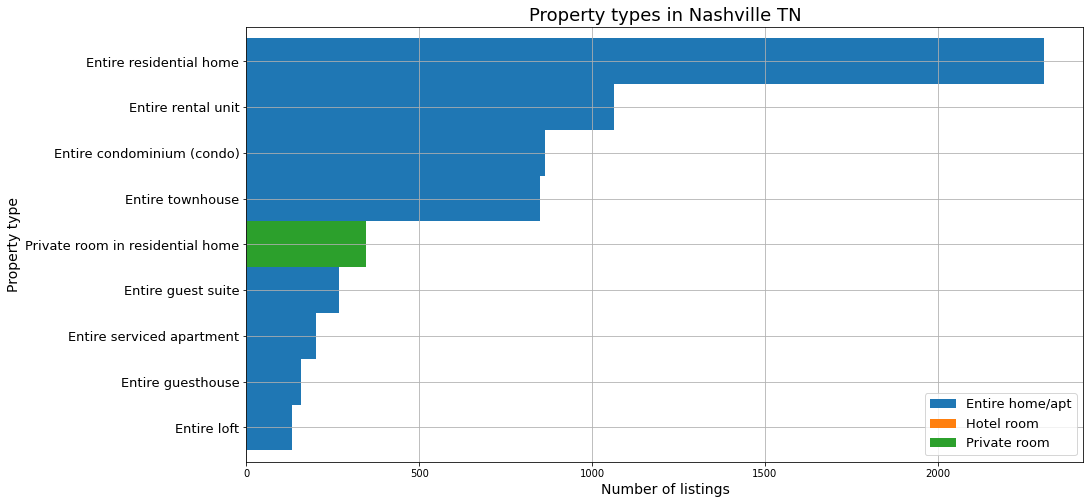

In [61]:
#Property type vs number of listings

prop = listings_details.groupby(['property_type','room_type']).room_type.count() #Counting the number of rooms by property type
prop = prop.unstack() #Unstacking the dataframe
prop['total'] = prop.iloc[:,0:3].sum(axis = 1) #Summing the rooms by property type
prop = prop.sort_values(by=['total']) #Sorting the dataframe by total rooms
prop = prop[prop['total']>=100] #Selecting the properties counting more than 100 
prop = prop.drop(columns=['total']) #Dropping the total column

prop.plot(kind='barh',stacked=True, linewidth = 1, grid=True, figsize=(15,8), width=1) #Plotting the dataframe
plt.title('Property types in Nashville TN', fontsize=18) #Setting the title
plt.xlabel('Number of listings', fontsize=14) #Setting the xlabel
plt.ylabel("Property type", fontsize=14) #Setting the ylabel
plt.legend(loc = 4,prop = {"size" : 13}) #Setting the legend
plt.rc('ytick', labelsize=13)  #Setting the fontsize of the ytick labels
print ("Property types in Nashville TN") #Printing the title
plt.show() #Showing the plot

The most common number of people in a room is 4, asuming a family renting


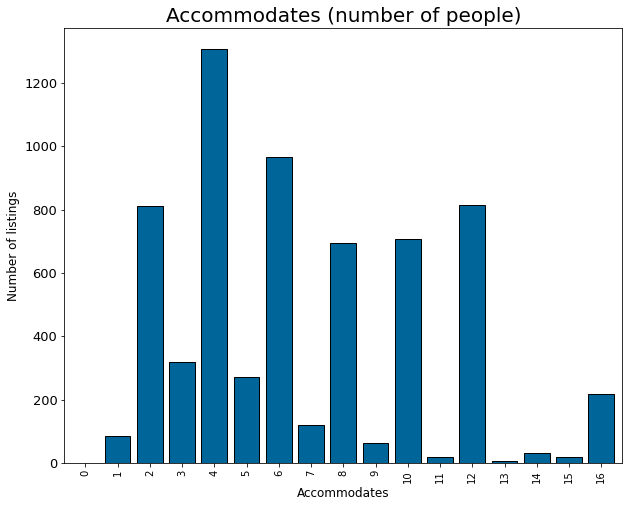

In [62]:
feq=listings_details['accommodates'].value_counts().sort_index() #Value counts of accommodates
feq.plot.bar(figsize=(10, 8), color='#006699', width=0.8, edgecolor='black', linewidth=1) #Plotting the dataframe
plt.title("Accommodates (number of people)", fontsize=20) #Setting the title
plt.ylabel('Number of listings', fontsize=12) #Setting the ylabel
plt.xlabel('Accommodates', fontsize=12) #Setting the xlabel
print("The most common number of people in a room is 4, asuming a family renting") #Printing the title
plt.show() #Showing the plot

In [63]:
#Map of the property types
lats_nash = listings_details['latitude'].tolist() #latitude of the listings
lons_nash = listings_details['longitude'].tolist() #longitude of the listings 
locations = list(zip(lats_nash, lons_nash)) #zip the latitude and longitude

map1 = folium.Map(location=[ 36.36133, -86.72463], zoom_start=11) #create a map
FastMarkerCluster(data=locations).add_to(map1) #add the locations to the map
map1 #show the map

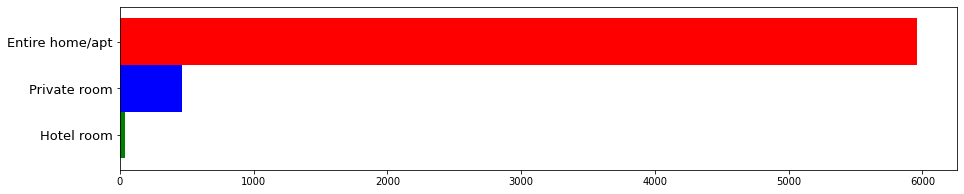

In [79]:
#Hows the property types are distributed in Nashville
freq = listings_details['room_type']. value_counts().sort_values(ascending=True) #room type frequency
freq.plot.barh(figsize=(15, 3), width=1, color = ["g","b","r"]) #configure the plot
plt.show() #show the plot


In [82]:

private = listings_details[listings_details.room_type == "Private room"] #select the private room listings
private.price.describe() #describe the price of the private room listings

count     464.000000
mean      116.396552
std       128.642581
min        21.000000
25%        51.750000
50%        82.500000
75%       113.250000
max      1206.000000
Name: price, dtype: float64

<AxesSubplot:ylabel='Frequency'>

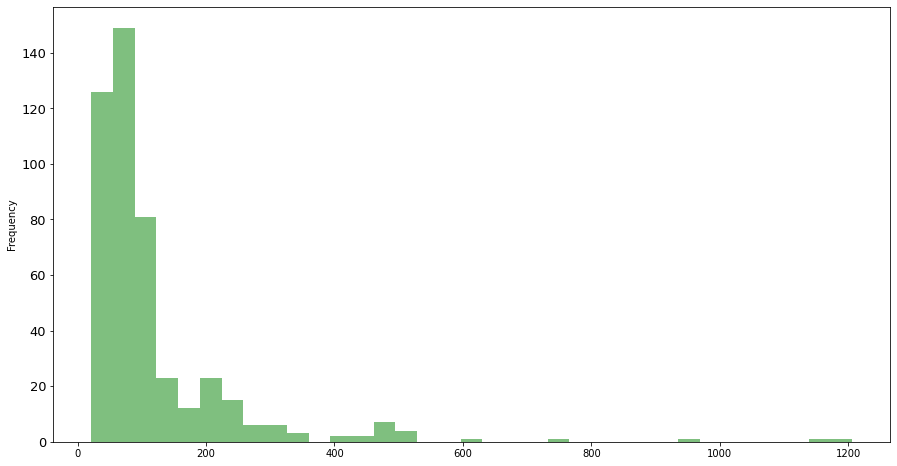

In [90]:
private.price.plot.hist(bins=35, figsize=(15, 8), color = "g", alpha = 0.5,  linewidth = 1) #plot the histogram of the prices in the private room listings

/home/dm/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='price', ylabel='Density'>

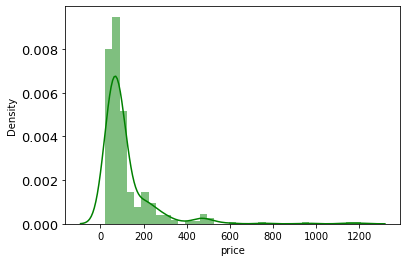

In [93]:
sns.distplot(private.price, bins=35, color = "g", hist_kws={"linewidth": 1, "alpha": 0.5}) #plot the histogram of the prices in the private room listings

In [94]:
px.histogram(private, x="price", color="room_type", histnorm="probability") #plot the histogram of the prices in the private room listings

Reviews clasification data analysis: <br>
The objetive is clasificate the reviews into 3 categories: <br>
Positive, Negative and Neutral to analyse the sentiment and understand the quality of the reviews.

In [111]:
reviewsDF = reviews.copy()
sid = SentimentIntensityAnalyzer()

reviewsDF['polarity_value']="Default"
reviewsDF['neg']=0.0
reviewsDF['pos']=0.0
reviewsDF['neu']=0.0
reviewsDF['compound']=0.0
for index,row in reviewsDF.iterrows():
    ss = sid.polarity_scores(row['comments'])
    reviewsDF.at[index,'polarity_value'] = ss
    reviewsDF.at[index,'neg'] = ss['neg']
    reviewsDF.at[index,'pos'] = ss['pos']
    reviewsDF.at[index,'neu']= ss['neu']
    reviewsDF.at[index,'compound'] = ss['compound']
reviewsDF.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,polarity_value,neg,pos,neu,compound
0,6422,1927,2009-04-30,14100,Melissa,I can't say enough about how wonderful it was ...,"{'neg': 0.008, 'neu': 0.659, 'pos': 0.333, 'co...",0.008,0.333,0.659,0.9942
1,6422,3867,2009-06-11,17413,Raquel,Michelle and Collier's home is wonderful! They...,"{'neg': 0.0, 'neu': 0.601, 'pos': 0.399, 'comp...",0.000,0.399,0.601,0.9953
2,6422,4159,2009-06-17,20253,Ulrike,I spent one night at Michele's home and felt j...,"{'neg': 0.0, 'neu': 0.687, 'pos': 0.313, 'comp...",0.000,0.313,0.687,0.9763
3,6422,5724,2009-07-18,22544,Phil,Michele and Collier are two of the loveliest p...,"{'neg': 0.018, 'neu': 0.78, 'pos': 0.202, 'com...",0.018,0.202,0.780,0.9680
4,6422,11891,2009-09-29,33409,Claire,We had the most lovely time staying with Miche...,"{'neg': 0.04, 'neu': 0.692, 'pos': 0.268, 'com...",0.040,0.268,0.692,0.9805


In [112]:
reviewsDF.to_csv('/home/dm/Desktop/airbnb/input/polarity_values_reviews.csv') #save the dataframe to a csv file

In [113]:
from langdetect import detect

def detect_lang(sente):
    sente=str(sente)
    try:
        return detect(sente)
    except:
        return "None"

for index,row in reviewsDF.iterrows():
    lang=detect_lang(row['comments'])
    reviewsDF.at[index,'language'] = lang
#     print(lang)
    
#taking rows whose language is English
EngReviewsDF=reviewsDF[reviewsDF.language=='en']

EngReviewsDF.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments,polarity_value,neg,pos,neu,compound,language
0,6422,1927,2009-04-30,14100,Melissa,I can't say enough about how wonderful it was ...,"{'neg': 0.008, 'neu': 0.659, 'pos': 0.333, 'co...",0.008,0.333,0.659,0.9942,en
1,6422,3867,2009-06-11,17413,Raquel,Michelle and Collier's home is wonderful! They...,"{'neg': 0.0, 'neu': 0.601, 'pos': 0.399, 'comp...",0.000,0.399,0.601,0.9953,en


In [114]:
polarDF=EngReviewsDF[['pos']]
polarDF=polarDF.groupby(pd.cut(polarDF["pos"], np.arange(0, 1.1, 0.1))).count()
polarDF=polarDF.rename(columns={'pos':'count_of_Comments'})
polarDF=polarDF.reset_index()
polarDF=polarDF.rename(columns={'pos':'range_i'})
for i,r in polarDF.iterrows():
    polarDF.at[i,'RANGE'] = float(str(r['range_i'])[1:4].replace(',',''))
    polarDF.at[i,'Sentiment'] = 'positive'
del polarDF['range_i']
polarDF.head()

,count_of_Comments,RANGE,Sentiment
0,6404,0.0,positive
1,43294,0.1,positive
2,98842,0.2,positive
3,102302,0.3,positive
4,68842,0.4,positive


In [115]:
polarDFneg=EngReviewsDF[['neg']]
polarDFneg=polarDFneg.groupby(pd.cut(polarDFneg["neg"], np.arange(0, 1.1, 0.1))).count()
polarDFneg=polarDFneg.rename(columns={'neg':'count_of_Comments'})
polarDFneg=polarDFneg.reset_index()
polarDFneg=polarDFneg.rename(columns={'neg':'range_i'})
for i,r in polarDFneg.iterrows():
    polarDFneg.at[i,'RANGE'] = float(str(r['range_i'])[1:4].replace(',',''))
    polarDFneg.at[i,'Sentiment'] = 'negative'
del polarDFneg['range_i']
for i,r in polarDFneg.iterrows():
    polarDF=polarDF.append(pd.Series([r[0],r[1],r[2]],index=['count_of_Comments','RANGE','Sentiment']),ignore_index=True)
    
polarDFneg.head()

<ipython-input-115-c779722cf62c>:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-115-c779722cf62c>:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-115-c779722cf62c>:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-115-c779722cf62c>:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-115-c779722cf62c>:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-115-c779722cf62c>:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future versi

,count_of_Comments,RANGE,Sentiment
0,61648,0.0,negative
1,7063,0.1,negative
2,1038,0.2,negative
3,281,0.3,negative
4,124,0.4,negative


In [116]:
polarDFneut=EngReviewsDF[['neu']]
polarDFneut=polarDFneut.groupby(pd.cut(polarDFneut["neu"], np.arange(0, 1.0, 0.1))).count()
polarDFneut=polarDFneut.rename(columns={'neu':'count_of_Comments'})
polarDFneut=polarDFneut.reset_index()
polarDFneut=polarDFneut.rename(columns={'neu':'range_i'})
for i,r in polarDFneut.iterrows():
    polarDFneut.at[i,'RANGE'] = float(str(r['range_i'])[1:4].replace(',',''))
    polarDFneut.at[i,'Sentiment'] = 'neutral' 
del polarDFneut['range_i']

for i,r in polarDFneut.iterrows():
    polarDF=polarDF.append(pd.Series([r[0],r[1],r[2]],index=['count_of_Comments','RANGE','Sentiment']),ignore_index=True)
    
polarDFneut.head()

<ipython-input-116-68960d32aaba>:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-116-68960d32aaba>:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-116-68960d32aaba>:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-116-68960d32aaba>:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-116-68960d32aaba>:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-116-68960d32aaba>:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future versi

,count_of_Comments,RANGE,Sentiment
0,231,0.0,neutral
1,8613,0.1,neutral
2,12139,0.2,neutral
3,21428,0.3,neutral
4,43356,0.4,neutral


/home/dm/.local/lib/python3.8/site-packages/seaborn/categorical.py:3717: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



<Figure size 720x720 with 0 Axes>

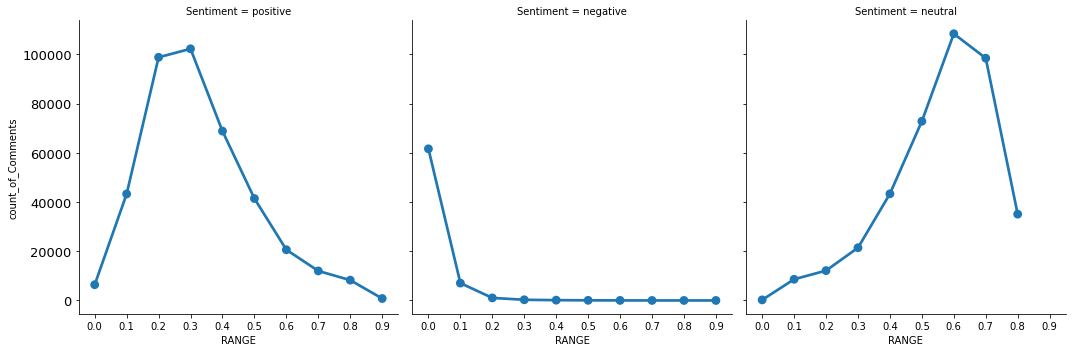

In [117]:

plt.figure(figsize=(10,10))
sns.factorplot(data=polarDF, x="RANGE", y="count_of_Comments",col="Sentiment") 

/home/dm/.local/lib/python3.8/site-packages/seaborn/categorical.py:3717: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



<Figure size 720x720 with 0 Axes>

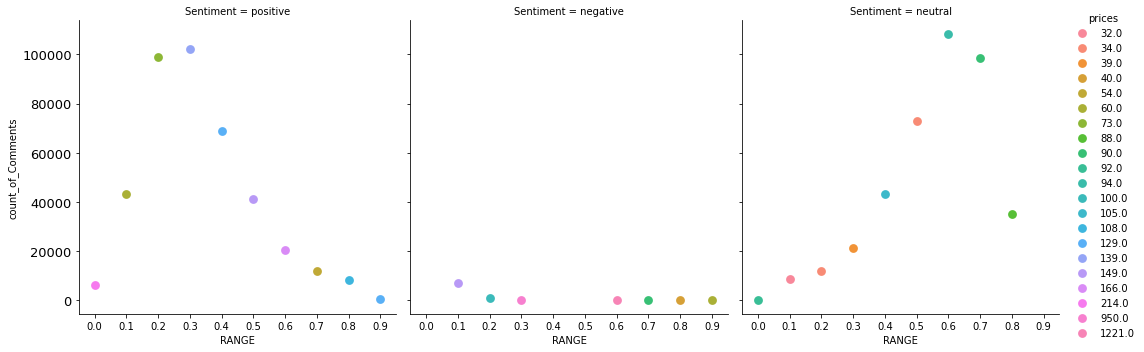

In [119]:
plt.figure(figsize=(10,10))
sns.factorplot(data=polarDF, x="RANGE", y="count_of_Comments",hue="prices",col="Sentiment")

In [122]:

#take out empty comments (530)
EngReviewsDF = EngReviewsDF[EngReviewsDF['comments'].notnull()]

#remove numbers
EngReviewsDF['comments'] = EngReviewsDF['comments'].str.replace('\d+', '') 
#all to lowercase
EngReviewsDF['comments'] = EngReviewsDF['comments'].str.lower()
#remove windows new line
EngReviewsDF['comments'] = EngReviewsDF['comments'].str.replace('\r\n', "")

#remove stopwords (from nltk library)
stop_english = stopwords.words("english")
EngReviewsDF['comments'] = EngReviewsDF['comments'].apply(lambda x: " ".join([i for i in x.split() 
                                                      if i not in (stop_english)]))
# remove punctuation
EngReviewsDF['comments'] = EngReviewsDF['comments'].str.replace('[^\w\s]'," ")
# replace x spaces by one space
EngReviewsDF['comments'] = EngReviewsDF['comments'].str.replace('\s+', ' ')

EngReviewsDF.comments.values[2] #print same comments again

<ipython-input-122-74e1211668b4>:5: FutureWarning:

The default value of regex will change from True to False in a future version.

<ipython-input-122-74e1211668b4>:16: FutureWarning:

The default value of regex will change from True to False in a future version.

<ipython-input-122-74e1211668b4>:18: FutureWarning:

The default value of regex will change from True to False in a future version.



'spent one night michele s home felt wonderful right home beautiful place michele family extraordinarily welcoming open minded warm generous would use better words describe english better looking nice place stay nashville want meet nicest people place be '

In [124]:
texts = EngReviewsDF.comments.tolist()

vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

cvec_df = pd.DataFrame.from_records(words_freq, columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
cvec_df.head(10)

,words,counts
55,great,271217
81,place,215230
4,stay,208722
306,location,142687
7,nashville,138400
310,clean,126582
74,would,106662
90,br,95737
29,house,86673
432,perfect,83310


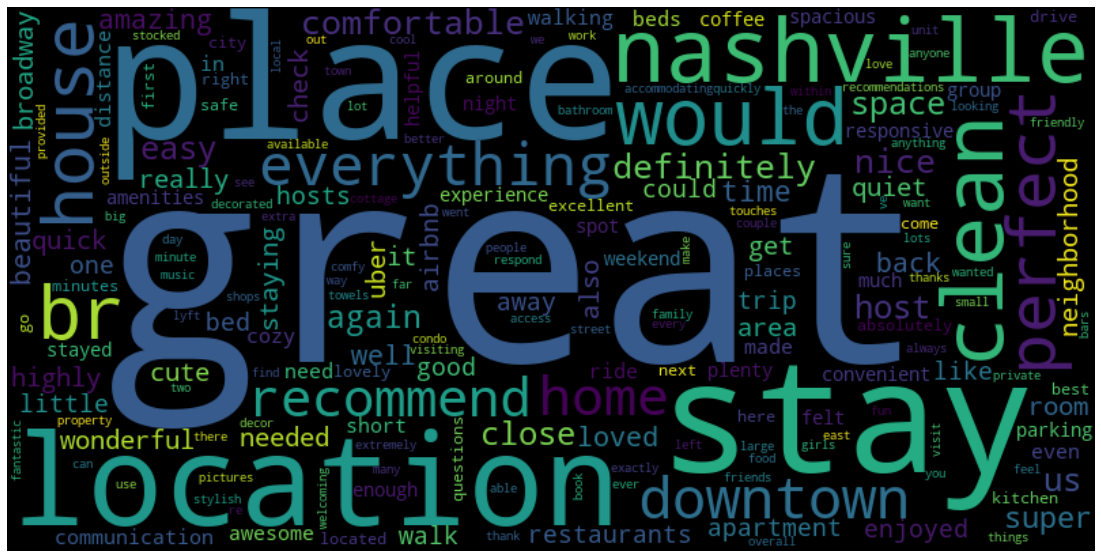

In [125]:
cvec_dict = dict(zip(cvec_df.words, cvec_df.counts))

wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=cvec_dict)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()